In [1]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import pymc3 as pm
import bokeh

In [2]:
CC_DATA_FILEPATH = "./data/CC GENERAL.csv"
cc = pd.read_csv(CC_DATA_FILEPATH)
cc.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
cc.shape

(8950, 18)

This data gives individual credit card transactios for specific customers (`CUST_ID`). The most granular form of transaction data would have one record per transaction. This appears to be summarized from such data and shows counts and totals of transactions per customer. This level of granularity will be important when crafting our model hierarchy.

In [6]:
len(pd.unique(cc['CUST_ID']))

8950

The data is unique by `CUST_ID`, as expected. We can use this field as an index.

In [7]:
cc.set_index('CUST_ID', inplace=True)
cc.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


Let's start my analyzing the most economically impactful variables. These are:
- `PURCHASES`: The total amount of all purchases during the period.
- `PURCHASES_TRX`: The count of transactions during the period.

(array([6.452e+03, 1.241e+03, 5.330e+02, 2.620e+02, 1.570e+02, 1.020e+02,
        5.000e+01, 3.100e+01, 2.900e+01, 2.200e+01, 1.100e+01, 1.600e+01,
        9.000e+00, 2.000e+00, 7.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 5.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([    0.    ,   980.7914,  1961.5828,  2942.3742,  3923.1656,
         4903.957 ,  5884.7484,  6865.5398,  7846.3312,  8827.1226,
         9807.914 , 10788.7054, 11769.4968, 12750.2882, 13731.0796,
        14711.871 , 15692.6624, 16673.4538, 17654.2452, 18635.0366,
        19615.828 , 20596.6194, 21577.4108, 22558.2022, 23538.9936,
        24519.785 , 25500.5764, 2648

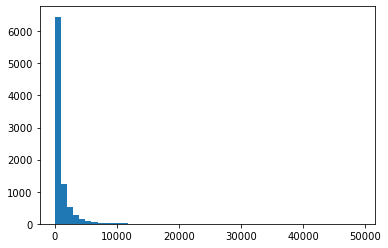

In [14]:
plt.hist(cc['PURCHASES'], bins=50)

Most purchases have a low dollar amount, with a thin tail of high amount purchases. This looks like it follows a gamma distribution.